<center><h2>A binary classification task of pulsar stars</h2>
<i>based on a dataset from <a href="https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star">kaggle.com</a></i></center>
<b>Contents:</b>
<ol>
    <li>Introduction</li>
    <li>Data preparation</li>
    <li>Preliminary studies</li>
    <li>Score and resampling</li>
    <li>Models</li>
    <ul>
        <li>Linear SVM</li>
        <li>K Nearest Neighbors</li>
        <li>Polynomial SVM</li>
        <li>PCA + Linear SVM</li>
        <li>Neural Network</li>
    </ul>
    <li>End results</li>
</ol>



<h3>1. Introduciton</h3>
<p>This is a study exploring a binary classification task for pulsar stars. We describe our approach to the problem and shortly discuss our reasoning.</p>

<p>On the level of data preparation, we have identified and addressed the problem of imbalanced datasets by resampling the training set using the <a href="iojio">SMOTE algorithm</a>. Moreover, as a performance measure we use the Precision-Recall Plot and Average Precision scoring as <a href="saito2015.pdf">more suitable measure</a> for binary classification tasks for imbalanced datasets.  

<p>The choice of models is quite conservative. First choice of Support Vector Machines and K Nearest Neighbors Model essentially follows the <a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">scikit-learn flow-chart</a>. Besides that, we also apply the Principal Component Analysis (PCA) as a preliminary step in the pipeline as the characteristics provided in the dataset could be depedendent. Lastly, we decide to train a simple Neural Network Model.</p>


<h3>2. Data preparation</h3>

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import average_precision_score,precision_recall_curve
from sklearn.model_selection import GridSearchCV

#SMOTE algorithm
from imblearn.over_sampling import SMOTE,BorderlineSMOTE


In [3]:
data = pd.read_csv('pulsar_stars.csv')

# rename columns
newcols = ['mean_profile','std_profile','kurt_profile','skew_profile','mean_curve','std_curve','kurt_curve','skew_curve','target_class']
oldcols = data.columns.to_list()
data = data.rename(columns=dict(zip(oldcols,newcols)))

# sklearn split into train/test datasets
Xtrain,Xtest,ytrain,ytest = train_test_split(data.iloc[:,:-1],data.iloc[:,-1],random_state=0,train_size=0.8)
datatrain = pd.concat([Xtrain,ytrain],ignore_index=False,axis=1)
datetest = pd.concat([Xtest,ytest],ignore_index=False,axis=1)

# summary of studied models
model_results = pd.DataFrame()


<h3>3. Preliminary studies</h3>

              mean_profile  std_profile  kurt_profile  skew_profile  \
mean_profile      1.000000     0.549804     -0.876250     -0.741640   
std_profile       0.549804     1.000000     -0.526139     -0.543705   
kurt_profile     -0.876250    -0.526139      1.000000      0.946182   
skew_profile     -0.741640    -0.543705      0.946182      1.000000   
mean_curve       -0.300813     0.005110      0.413890      0.410917   
std_curve        -0.313302    -0.052372      0.436995      0.418872   
kurt_curve        0.243241     0.036216     -0.346322     -0.333477   
skew_curve        0.152848     0.034563     -0.219231     -0.209297   
target_class     -0.677220    -0.366648      0.790853      0.706890   

              mean_curve  std_curve  kurt_curve  skew_curve  target_class  
mean_profile   -0.300813  -0.313302    0.243241    0.152848     -0.677220  
std_profile     0.005110  -0.052372    0.036216    0.034563     -0.366648  
kurt_profile    0.413890   0.436995   -0.346322   -0.219231  

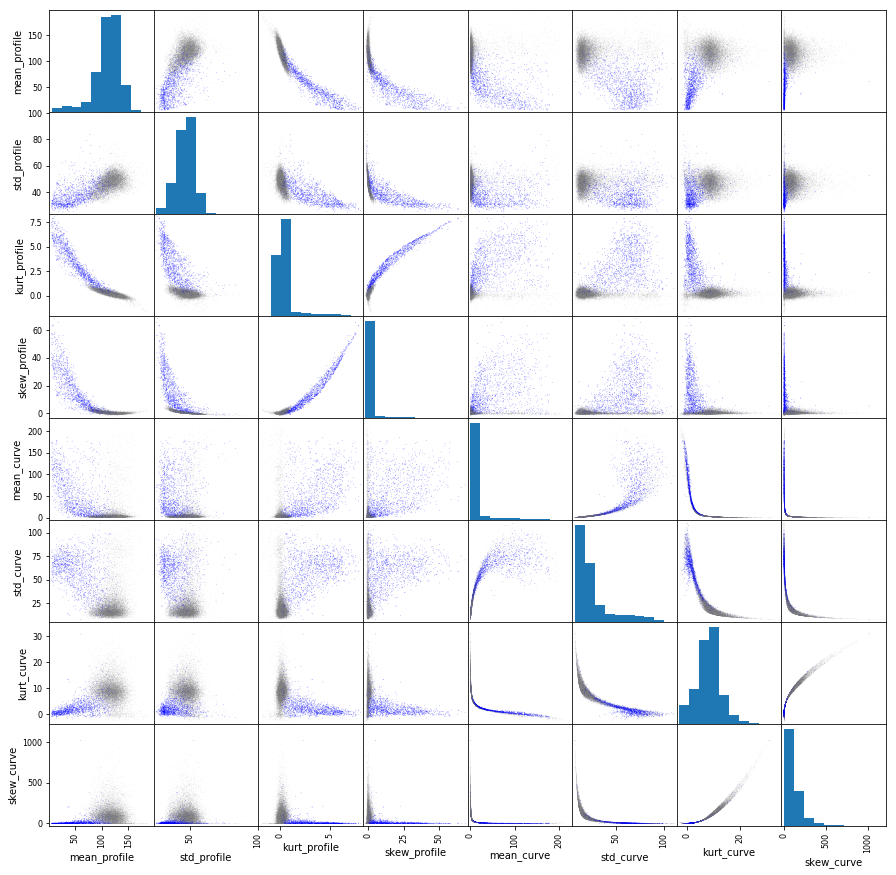

In [8]:
#correlation matrix
print(datatrain.corr())

#scatter_matrix plots for train dataset 

color = {1:'blue',0:'gray'}
sizes = {1:2,0:.5}
datasample = datatrain.sample(frac=1)[:]
#datasample.plot.scatter(x='mean_profile',y='std_profile',figsize=[6,6],c=datasample['target_class'].apply(lambda x: color[x]),marker='x')
#plot = datasample.plot.scatter(x='skew_curve',y='kurt_curve',figsize=[5,5],c=datasample['target_class'].apply(lambda x: color[x]),marker='.',s=datasample['target_class'].apply(lambda x: sizes[x]))

plots = pd.plotting.scatter_matrix(datasample.iloc[:,:-1],figsize=[15,15],c=datasample['target_class'].apply(lambda x: color[x]),marker='.',s=datasample['target_class'].apply(lambda x: sizes[x]))


<h3>4. Score and resampling</h3>

Average precision-recall score: 0.9281656572303744



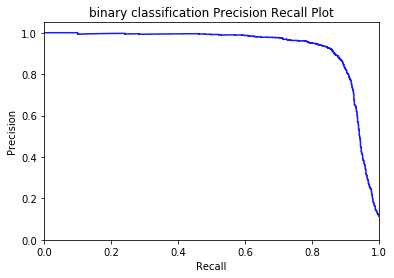

In [55]:
# Precision Recall Plot function
def PrecisionRecallPlot(classifier,Xtrain,ytrain):
    classifier.fit(X=Xtrain,y=ytrain)
    y_score = classifier.decision_function(Xtrain)

    average_precision = average_precision_score(ytrain, y_score)
    precision, recall, thresholds = precision_recall_curve(ytrain, y_score)
    print()
    plt.step(recall, precision, color='b', alpha=0.9,
             where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('binary classification Precision Recall Plot')
    plt.show()

# Average Precision Recall Score function
def AvPrecisionRecallScore(classifier,Xtrain,ytrain):
    classifier.fit(X=Xtrain,y=ytrain)
    y_score = classifier.decision_function(Xtrain)
    average_precision = average_precision_score(ytrain, y_score)
    return average_precision

# basic PR Plot
clfSVC = LinearSVC(C=1,dual=False,class_weight={0:1,1:1})
print('Average precision-recall score:',AvPrecisionRecallScore(clfSVC,Xtrain,ytrain))
PrecisionRecallPlot(clfSVC,Xtrain,ytrain)


Average precision-recall score: 0.9815348711029783



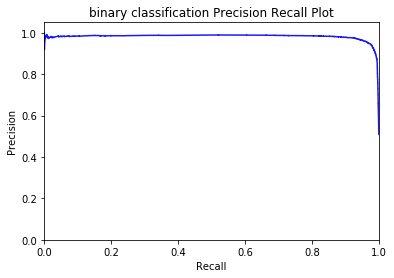

In [56]:
# resampling with SMOTE algorithm

#resampler = SMOTE()
resampler = BorderlineSMOTE()
Xtrain_resampled,ytrain_resampled = resampler.fit_resample(Xtrain,ytrain)

# improvement of PR Plot due to resampling
clfSVC = LinearSVC(C=1,dual=False,class_weight={0:1,1:1})
print('Average precision-recall score:',AvPrecisionRecallScore(clfSVC,Xtrain_resampled,ytrain_resampled))
PrecisionRecallPlot(clfSVC,Xtrain_resampled,ytrain_resampled)

<h3>5. Models</h3>

In [76]:
MgridParams = {}

MgenParams = {}
Mdatasets = {}

Mfound = {}
Mclfs = {}

#define parameters scope for GridSearchCV
MgridParams['LinearSVC'] = [{'C':[0.5,1,1.5,2],'class_weight':[None]}]
MgridParams['KNearestNeighbors'] = [{'n_neighbors':[1,2,3,4,5,6],'weights':['distance','uniform']}]
MgridParams['PolySVC'] = [{'kernel':['poly'],'class_weight':[{0:1,1:1},{0:8,1:1},'balanced'],'degree':[3,4,5,6]}]
MgridParams['PCALinearSVC'] = [{'C':[0.5,1,1.5,2],'class_weight':[None]}]
MgridParams['NeuralNetwork'] = [{'hidden_layer_size':[(8,4,2,),(6,2,1,),(6,2,)],'max_iter':[400],'activation':['relu','tanh']}]

#define general parameters
MgenParams['LinearSVC'] = {'cv':StratifiedKFold(n_splits=5,shuffle=True),'scoring':'average_precision','n_jobs':-1}

#define datasets
Mdatasets['LinearSVC'] = {'X':Xtrain,'y':ytrain}

for m in Mparams:
    Mfound[m] = False

In [ ]:
for m in Mparams:
    if not Mfound[m]:
        

In [77]:
clf = GridSearchCV(LinearSVC(dual=False),Mparams['LinearSVC'],**MgenParams['LinearSVC'])
clf.fit(**Mdatasets['LinearSVC'])
res = pd.DataFrame(clf.cv_results_)

In [78]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.114553,0.020306,0.049699,0.024421,0.5,None,"{'C': 0.5, 'class_weight': None}",0.930994,0.949363,0.906167,0.914954,0.938265,0.927949,0.015606,2
1,0.213268,0.027321,0.067062,0.031516,1,None,"{'C': 1, 'class_weight': None}",0.931023,0.949454,0.902019,0.915286,0.938480,0.927252,0.016812,3
2,0.248676,0.055781,0.043247,0.021899,1.5,None,"{'C': 1.5, 'class_weight': None}",0.930715,0.949468,0.901552,0.915357,0.938857,0.927190,0.016984,4
3,0.127651,0.027912,0.056559,0.027705,2,None,"{'C': 2, 'class_weight': None}",0.931039,0.949532,0.906159,0.915492,0.938837,0.928212,0.015644,1


In [58]:

from sklearn.svm import LinearSVC

parameters = [{'C':[2+i/10 for i in range(1,21)],'class_weight':[None]}]
allresults = []
scv = 

for score in scorings:
    
    clf = GridSearchCV(LinearSVC(dual=False),parameters,cv=scv,scoring=score,n_jobs=-1)
    clf.fit(X=Xtrain,y=ytrain)
    
    res = pd.DataFrame(clf.cv_results_)
    res['score'] = score
    allresults.append(res)

#update model_results
data = []
for result in allresults:
    temp = result[result['rank_test_score']==1].iloc[0,:][['mean_test_score','std_test_score','params','score']]
    temp['method'] = 'LinearSVC'
    data.append(temp)


model_results = model_results.append(pd.DataFrame(data))
model_results.drop_duplicates(subset=['mean_test_score','std_test_score','score','method'],inplace=True)



In [59]:
models_params

{'LinearSVC': [{'C': [2.1,
    2.2,
    2.3,
    2.4,
    2.5,
    2.6,
    2.7,
    2.8,
    2.9,
    3.0,
    3.1,
    3.2,
    3.3,
    3.4,
    3.5,
    3.6,
    3.7,
    3.8,
    3.9,
    4.0],
   'class_weight': [None]}]}

In [16]:
# SVM one example of a linear kernel

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

clf = LinearSVC(C=10,dual=False,class_weight={0:9,1:1})
#clf2 = SVC(kernel='linear',C=2,class_weight={0:1,1:1})

scv = StratifiedKFold(n_splits=6)
#cv = KFold(n_splits = 5)

scores = cross_val_score(clf,X=Xtrain,y=ytrain,cv=scv,scoring='average_precision')
#scores2 = cross_val_score(clf,X=Xtrain,y=ytrain,cv=cv)

print('precision with LinearSVC with cv=scv: ',np.mean(scores),'+/-',np.std(scores))
#print('precision with LinearSVC with cv=cv: ',np.mean(scores2),'+/-',np.std(scores2))

precision with LinearSVC with cv=scv:  0.9202005342171599 +/- 0.01779703945058671


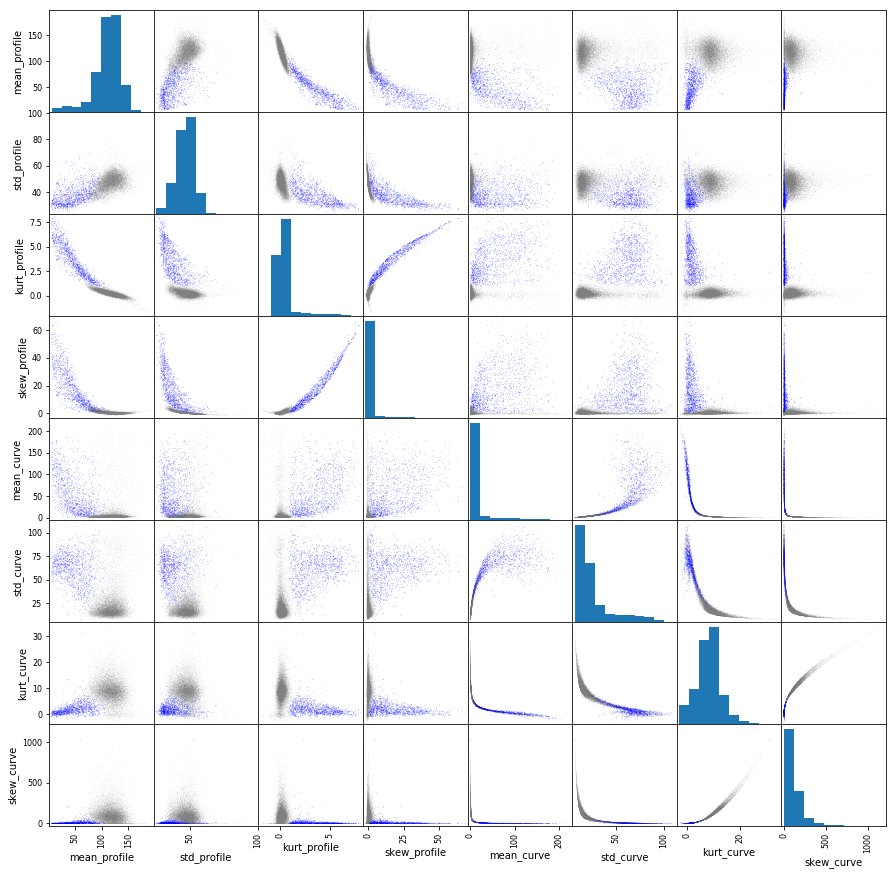

In [9]:
# scatter_matrix for model data

clf = LinearSVC(C=.1,dual=False,class_weight={0:1,1:1})
clf.fit(X=Xtrain,y=ytrain)
ytrainhat = clf.predict(Xtrain)

Xtrain2 = Xtrain.copy()
#Xtrain2['yreal'] = pd.DataFrame(ytrain)
#Xtrain2 = Xtrain.reset_index()
Xtrain2 = Xtrain2.reset_index()
Xtrain2['yhat'] = pd.DataFrame(ytrainhat)
Xtrain2 = Xtrain2.drop(columns='index')

color = {1:'blue',0:'gray'}
sizes = {1:2,0:.5}
datatrainhat = Xtrain2.copy()
datasample = datatrainhat.sample(frac=1)[:]

plots = pd.plotting.scatter_matrix(datasample.iloc[:,:-1],figsize=[15,15],c=datasample['yhat'].apply(lambda x: color[x]),marker='.',s=datasample['yhat'].apply(lambda x: sizes[x]))


In [10]:
# look for scorings
scorings = ['average_precision','f1']


In [47]:
# LinearSVC search parameters grid for some C parameters, weights and scores explained above. All the results are aggregated.

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

parameters = [{'C':[2+i/10 for i in range(1,21)],'class_weight':[None]}]
allresults = []
scv = StratifiedKFold(n_splits=5)

for score in scorings:
    
    clf = GridSearchCV(LinearSVC(dual=False),parameters,cv=scv,scoring=score,n_jobs=-1)
    clf.fit(X=Xtrain,y=ytrain)
    
    res = pd.DataFrame(clf.cv_results_)
    res['score'] = score
    allresults.append(res)

#update model_results
data = []
for result in allresults:
    temp = result[result['rank_test_score']==1].iloc[0,:][['mean_test_score','std_test_score','params','score']]
    temp['method'] = 'LinearSVC'
    data.append(temp)


model_results = model_results.append(pd.DataFrame(data))
model_results.drop_duplicates(subset=['mean_test_score','std_test_score','score','method'],inplace=True)

In [48]:
model_results

,mean_test_score,std_test_score,params,score,method
19,0.927208,0.012972,"{'C': 2.0, 'class_weight': None}",average_precision,LinearSVC
12,0.874477,0.018939,"{'C': 1.3, 'class_weight': None}",f1,LinearSVC
18,0.927417,0.012941,"{'C': 3.9, 'class_weight': None}",average_precision,LinearSVC
2,0.874470,0.018535,"{'C': 2.3, 'class_weight': None}",f1,LinearSVC


In [16]:
#KNearestNeighbors example
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5,weights='distance')

results = cross_val_score(clf,X=Xtrain,y=ytrain,cv=10,scoring='recall')
print(np.mean(results))

0.788262129669386


In [12]:
#KNearestNeighbors grid search
from sklearn.neighbors import KNeighborsClassifier

params = [{'n_neighbors':[1,2,3,4,5,6],'weights':['distance','uniform']}]
allresults = []
scv = StratifiedKFold(n_splits=5)

for score in scorings:
    
    clf = GridSearchCV(KNeighborsClassifier(),params,cv=scv,scoring=score,n_jobs=-1)
    clf.fit(X=Xtrain,y=ytrain)
    res = pd.DataFrame(clf.cv_results_)
    res['score'] = score
    allresults.append(res)

# update model_results
data = []
for result in allresults:
    temp = result[result['rank_test_score']==1].iloc[0,:][['mean_test_score','std_test_score','params','score']]
    temp['method'] = 'KNearestNeighbors'
    data.append(temp)


model_results = model_results.append(pd.DataFrame(data))
model_results.drop_duplicates(subset=['mean_test_score','std_test_score','score','method'],inplace=True)


In [13]:
model_results

,mean_test_score,std_test_score,params,score,method
10,0.927208,0.012972,"{'C': 2, 'class_weight': {0: 1, 1: 1}}",average_precision,LinearSVC
5,0.874244,0.019453,"{'C': 1.5, 'class_weight': {0: 1, 1: 1}}",f1,LinearSVC
10,0.845389,0.029745,"{'n_neighbors': 6, 'weights': 'distance'}",average_precision,KNearestNeighbors
8,0.840399,0.022001,"{'n_neighbors': 5, 'weights': 'distance'}",f1,KNearestNeighbors


In [14]:
#SVC grid search
from sklearn.svm import SVC


params = [{'kernel':['poly'],'class_weight':[{0:1,1:1},{0:8,1:1},'balanced'],'degree':[3,4,5,6]}]
scv = StratifiedKFold(n_splits=5)
allresults = []

for score in scorings:
    
    clf = GridSearchCV(SVC(gamma='scale'),params,cv=scv,scoring=score,n_jobs=-1)
    clf.fit(X=Xtrain,y=ytrain)
    res = pd.DataFrame(clf.cv_results_)
    res['score'] = score
    allresults.append(res)
    

# update model_results
data = []
for result in allresults:
    temp = result[result['rank_test_score']==1].iloc[0,:][['mean_test_score','std_test_score','params','score']]
    temp['method'] = 'SVC'
    data.append(temp)

model_results = model_results.append(pd.DataFrame(data))
model_results.drop_duplicates(subset=['mean_test_score','std_test_score','score','method'],inplace=True)

In [61]:
#NaiveBayes example

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

scv = StratifiedKFold(n_splits=10)

score = cross_val_score(clf,X=Xtrain,y=ytrain,cv=scv,scoring='average_precision')
print(np.mean(score))

0.7385422848143663


In [64]:
#NaiveBayes grid search
from sklearn.naive_bayes import GaussianNB


params = [{}]
scv = StratifiedKFold(n_splits=5)
allresults = []

for score in scorings:
    
    clf = GridSearchCV(GaussianNB(),params,cv=scv,scoring=score,n_jobs=-1)
    clf.fit(X=Xtrain,y=ytrain)
    res = pd.DataFrame(clf.cv_results_)
    res['score'] = score
    allresults.append(res)
    

# update model_results
data = []
for result in allresults:
    temp = result[result['rank_test_score']==1].iloc[0,:][['mean_test_score','std_test_score','params','score']]
    temp['method'] = 'GaussianNB'
    data.append(temp)

model_results = model_results.append(pd.DataFrame(data))
model_results.drop_duplicates(subset=['mean_test_score','std_test_score','score','method'],inplace=True)

In [6]:
# PCA + LinearSVC

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold,cross_val_score

pca = PCA(n_components=3)
pca.fit(Xtrain)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

Xtrain_reduced = pca.transform(Xtrain)

clf = LinearSVC(dual=False,C=.5)
scv = StratifiedKFold(n_splits=6)

score = cross_val_score(clf,X=Xtrain_reduced,y=ytrain,cv=scv,scoring='average_precision')
print(np.mean(score))

[0.86777326 0.08027294 0.04224114]
[12859.28586675  3911.094543    2837.14493297]
0.8827732221824872


In [87]:
# MLPClassifier example
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(8,4,2,),max_iter=400,activation='relu')
scv = StratifiedKFold(n_splits=6)

score = cross_val_score(clf,X=XtrainScaled,y=ytrain,cv=scv,scoring='average_precision')
print(np.mean(score),'+/-',np.std(score))

0.9259564907180877 +/- 0.022521388264927677


In [50]:
clf.fit(X=Xtrain,y=ytrain)


array([[0.98437572, 0.01562428],
       [0.99319668, 0.00680332],
       [0.07474826, 0.92525174],
       ...,
       [0.99482324, 0.00517676],
       [0.99253617, 0.00746383],
       [0.99019463, 0.00980537]])

In [65]:
# create optimal models

import pickle
import os

model_scores =['recall','precision','f1']
model_clf = {'SVC':SVC,'LinearSVC':LinearSVC,'KNearestNeighbors':KNeighborsClassifier}
additional_model_params = {'SVC':{'gamma':'scale'},'LinearSVC':{'dual':False},'KNearestNeighbors':{}}


for model in model_scores:
    temp = model_results[model_results['score']==model].sort_values(by='mean_test_score',ascending=False).iloc[0,:]
    model_type = temp['method']
    parameters = temp['params']
    all_parameters = {**parameters,**additional_model_params[model_type]}
    filename = model+'_model_'+model_type+'.pkl'
    
    print('creating optimal model *'+filename+'* with parameters '+str(all_parameters))
    clf = model_clf[model_type](**all_parameters)
    clf.fit(X=Xtrain,y=ytrain)
    # save the model
    with open(filename,'wb') as f: pickle.dump(clf,f)


creating optimal model *recall_model_SVC.pkl* with parameters {'class_weight': 'balanced', 'degree': 6, 'kernel': 'poly', 'gamma': 'scale'}
creating optimal model *precision_model_SVC.pkl* with parameters {'class_weight': {0: 8, 1: 1}, 'degree': 4, 'kernel': 'poly', 'gamma': 'scale'}
creating optimal model *f1_model_LinearSVC.pkl* with parameters {'C': 1.5, 'class_weight': {0: 1, 1: 1}, 'dual': False}


In [70]:
# load optimal models
with open('precision_model_SVC.pkl','rb') as f:
    clf = pickle.load(f)
    
clf.predict(Xtrain)

array([0, 0, 0, ..., 0, 0, 0])

Average precision-recall score: 0.98


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

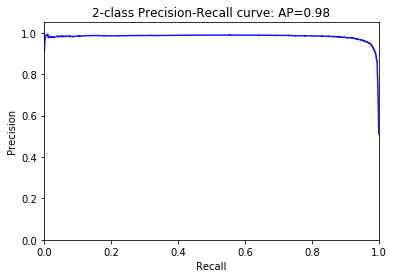

In [39]:
from sklearn.metrics import average_precision_score

clfSVC = LinearSVC(C=1,dual=False,class_weight={0:1,1:1})
clfSVC.fit(X=Xtrain2,y=ytrain2)

y_score = clfSVC.decision_function(Xtrain2)

average_precision = average_precision_score(ytrain2, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(ytrain2, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument

plt.step(recall, precision, color='b', alpha=0.9,
         where='post')
#plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain)
XtrainScaled = scaler.transform(Xtrain)

In [88]:
clf = LinearSVC(dual=False,C=2)
scv = StratifiedKFold(n_splits=5)
score = cross_val_score(clf,X=XtrainScaled,y=ytrain,cv=scv,scoring='average_precision')
np.mean(score)

0.9275119688468744

In [94]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy')
scv = StratifiedKFold(n_splits=5)
score = cross_val_score(clf,X=Xtrain,y=ytrain,cv=scv,scoring='average_precision')
print(np.mean(score),'+/-',np.std(score))

0.7007578118115946 +/- 0.009483069673287535


In [163]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=25,criterion='entropy',min_samples_split=10,min_samples_leaf=10,max_features=7,max_leaf_nodes=20,n_jobs=-1)
scv = StratifiedKFold(n_splits=5)
score = cross_val_score(clf,X=Xtrain,y=ytrain,cv=scv,scoring='average_precision')
print(np.mean(score),'+/-',np.std(score))

0.9315130068787443 +/- 0.010769414189563283


In [4]:
#resampling
from imblearn.over_sampling import SMOTE,BorderlineSMOTE

resampler = SMOTE()

Xtrain2,ytrain2 = resampler.fit_resample(Xtrain,ytrain)

/home/grela/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [11]:

# SVM one example of a linear kernel

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

clf = LinearSVC(C=10,dual=False,class_weight=None)
#clf2 = SVC(kernel='linear',C=2,class_weight={0:1,1:1})

scv = StratifiedKFold(n_splits=6)
#cv = KFold(n_splits = 5)

scores = cross_val_score(clf,X=Xtrain2,y=ytrain2,cv=scv,scoring='average_precision')
#scores2 = cross_val_score(clf,X=Xtrain,y=ytrain,cv=cv)

print('precision with LinearSVC with cv=scv: ',np.mean(scores),'+/-',np.std(scores))
#print('precision with LinearSVC with cv=cv: ',np.mean(scores2),'+/-',np.std(scores2))

precision with LinearSVC with cv=scv:  0.9832739600604391 +/- 0.002739778486430764


In [26]:
#KNearestNeighbors example
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=23,weights='distance')
scv = StratifiedKFold(n_splits=6)

results = cross_val_score(clf,X=Xtrain2,y=ytrain2,cv=scv,scoring='average_precision')
print('precision with KNN with cv=scv: ',np.mean(results),'+/-',np.std(results))

precision with KNN with cv=scv:  0.988523487616117 +/- 0.002031496758238255


In [33]:
#SVC example
from sklearn.svm import SVC

clf = SVC(kernel='poly',gamma='scale',degree=4)
scv = StratifiedKFold(n_splits=3)

results = cross_val_score(clf,X=Xtrain2,y=ytrain2,cv=scv,scoring='average_precision')
print('precision with SCV(poly) with cv=scv: ',np.mean(results),'+/-',np.std(results))

precision with SCV(poly) with cv=scv:  0.9731824765645986 +/- 0.0019577011243961315


In [43]:
# MLPClassifier example
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(4,2,1,),max_iter=400,activation='logistic')
scv = StratifiedKFold(n_splits=6)

score = cross_val_score(clf,X=Xtrain2,y=ytrain2,cv=scv,scoring='average_precision')
print(np.mean(score),'+/-',np.std(score))

0.8701546013613806 +/- 0.24723758148927708


In [47]:
from sklearn.metrics import average_precision_score, accuracy_score
#clf = KNeighborsClassifier(n_neighbors=23,weights='distance')
clf = LinearSVC(C=10,dual=False,class_weight=None)
#clf = SVC(kernel='poly',gamma='scale',degree=4)
#clf = MLPClassifier(hidden_layer_sizes=(4,2,1,),max_iter=400,activation='logistic')
clf.fit(Xtrain2,ytrain2)

yhat = clf.predict(Xtest)
average_precision_score(yhat,ytest)
accuracy_score(yhat,ytest)

0.9748603351955307

In [48]:
from sklearn.metrics import confusion_matrix

confusion_matrix(yhat,ytest)

array([[3239,   23],
       [  67,  251]])